In [10]:
import imageio as iio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from pathlib import Path
import segment
from scipy import ndimage as ndi
from skimage import color, feature, filters, morphology, measure, segmentation, util
from stl import mesh
import sys
import yaml
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in Images

Loading images...
--> Images loaded as 3D array:  (20, 1024, 1004)
--> Size of array (GB):  0.04112384
Plotting images: [0, 5, 10, 15]


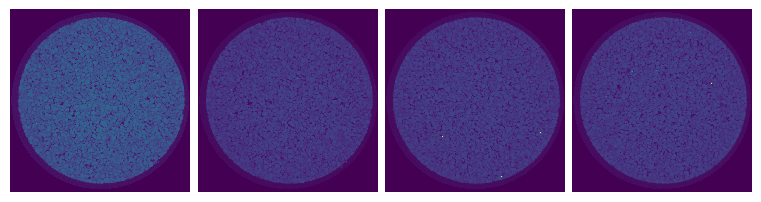

In [11]:
# Read YAML input file
yaml_file = Path(r'C:\Users\gusb\Research\PSAAP\segmentflow-input-gus.yml')
stream = open(yaml_file, 'r')
UI = yaml.load(stream,Loader=yaml.FullLoader)   # User Input
stream.close()
# Process User Input
ui_ct_img_dir           = UI['Files']['CT Scan Dir']
ui_stl_dir_location     = UI['Files']['STL Dir']
ui_output_filename_base = UI['Files']['STL Prefix']
ui_stl_overwrite        = UI['Files']['Overwrite Existing STL Files']
ui_single_particle_iso  = UI['Files']['Particle ID']
ui_suppress_save_msg    = UI['Files']['Suppress Save Messages']
ui_file_suffix          = UI['Load']['File Suffix']
ui_slice_crop           = UI['Load']['Slice Crop']
ui_row_crop             = UI['Load']['Row Crop']             
ui_col_crop             = UI['Load']['Col Crop']
ui_use_median_filter    = UI['Preprocess']['Apply Median Filter']
ui_rescale_range        = UI['Preprocess']['Rescale Intensity Range']
ui_n_otsu_classes       = UI['Binarize']['Number of Otsu Classes']
ui_n_selected_classes   = UI['Binarize']['Number of Classes to Select']
ui_use_int_dist_map     = UI['Segment']['Use Integer Distance Map']
ui_min_peak_distance    = UI['Segment']['Min Peak Distance']
ui_exclude_borders      = UI['Segment']['Exclude Border Particles']
ui_erode_particles      = UI['STL']['Erode Particles']    
ui_voxel_step_size      = UI['STL']['Marching Cubes Voxel Step Size']    
ui_spatial_res          = UI['STL']['Pixel-to-Length Ratio']
ui_show_segment_fig     = UI['Plot']['Show Segmentation Figure']
ui_n_imgs               = UI['Plot']['Number of Images']
ui_plot_maxima          = UI['Plot']['Plot Maxima']
ui_show_label_fig       = UI['Plot']['Show Particle Labels Figure']
ui_label_idx            = UI['Plot']['Particle Label Image Index']
ui_show_stl_fig         = UI['Plot']['Show Random STL Figure']
# Load images
print('Loading images...')
imgs = segment.load_images(
    ui_ct_img_dir,
    slice_crop=ui_slice_crop,
    row_crop=ui_row_crop,
    col_crop=ui_col_crop,
    convert_to_float=True,
    file_suffix=ui_file_suffix
)
print('--> Images loaded as 3D array: ', imgs.shape)
print('--> Size of array (GB): ', imgs.nbytes / 1E9)
# Plot images
fig, axes = segment.plot_imgs(imgs, n_imgs=4)
plt.show()

## Add preprocessing step

### Median filter followed by intensity rescale

Preprocessing images...
Applying median filter...
Rescaling intensities to percentile range [5, 95]...
--> Preprocessing complete
--> Size of array (GB):  0.04112384
Plotting images: [0, 5, 10, 15]


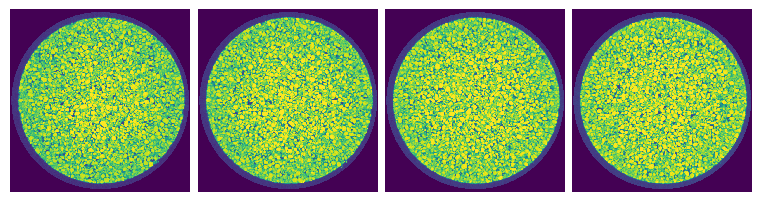

In [12]:
print('Preprocessing images...')
imgs_pre = segment.preprocess(
    imgs, median_filter=True, rescale_intensity_range=ui_rescale_range
)
print('--> Preprocessing complete')
print('--> Size of array (GB): ', imgs_pre.nbytes / 1E9)
# Plot preprocessed images
fig, axes = segment.plot_imgs(imgs_pre, n_imgs=4)
plt.show()

Binarizing images...
Calculating Otsu threshold(s)...
--> Binarization complete
--> Size of array (GB):  0.02056192
Plotting images: [0, 5, 10, 15]


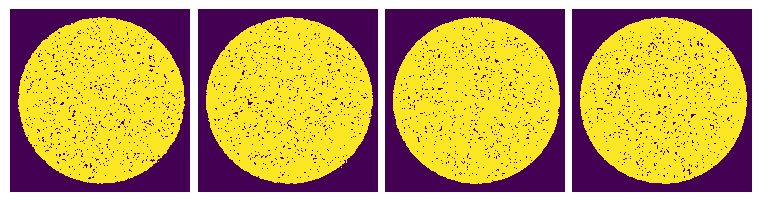

In [13]:
print('Binarizing images...')
# Borders must be excluded after seg. to avoid exclusion of connected regions
imgs_binarized, thresh_vals = segment.binarize_multiotsu(
    imgs_pre, n_otsu_classes=2, exclude_borders=False, 
)
print('--> Binarization complete')
print('--> Size of array (GB): ', imgs_binarized.nbytes / 1E9)
# Plot binarized images
fig, axes = segment.plot_imgs(imgs_binarized, n_imgs=4)
plt.show()

## Segment the Images

In [14]:
print('Segmenting images...')
segment_dict = segment.watershed_segment(
    imgs_binarized, min_peak_distance=ui_min_peak_distance, 
    use_int_dist_map=ui_use_int_dist_map, return_dict=True
)
print('--> Segmentation complete')

Segmenting images...
--> Segmentation complete


In [15]:
# sys.getsizeof() doesn't represent nested objects; need to add manually
print('--> Size of segmentation results (GB):')
dict_size = sys.getsizeof(segment_dict)
for key, val in segment_dict.items():
    print(f'----> {key}: {sys.getsizeof(val) / 1E9}')

--> Size of segmentation results (GB):
----> distance-map: 0.164495496
----> maxima: 4.0824e-05
----> integer-labels: 0.041123976


In [16]:
segment_dict['integer-labels'].dtype

dtype('uint16')

Plotting images: [0, 6, 12]


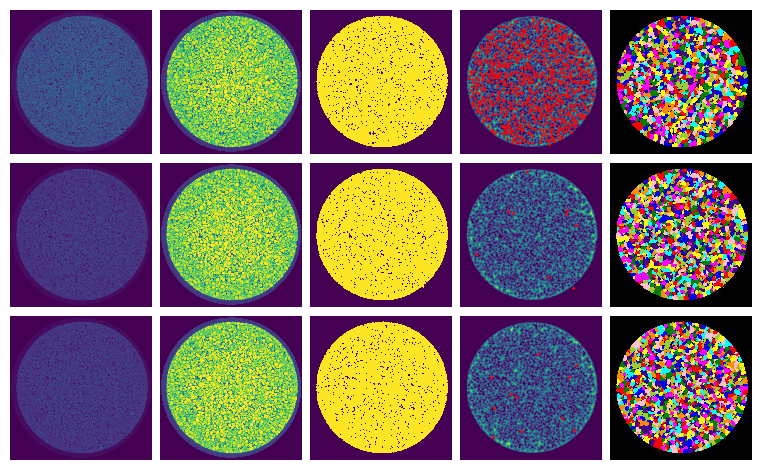

In [17]:
fig, axes = segment.plot_segment_steps(imgs, imgs_pre, imgs_binarized, segment_dict)
plt.show()

In [18]:
# How Many Particles Were Segmented?
n_particles = np.max(segment_dict['integer-labels'])
n_particles_digits = len(str(n_particles))
print('--> Total number of particles segmented: ' + str(n_particles))

--> Total number of particles segmented: 1696


Excluding border particles...
--> Total number of particles after border exclusion:  3
Plotting images: [0, 6, 12]


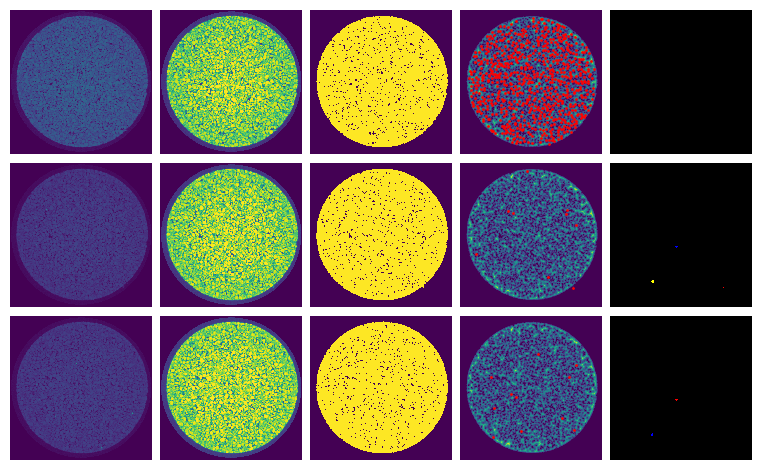

In [19]:
if ui_exclude_borders:
    print('Excluding border particles...')
    segment_dict['integer-labels'] = segmentation.clear_border(
        segment_dict['integer-labels']
    )
    nvoxels_by_ID_dict = segment.count_segmented_voxels(segment_dict)
    n_particles_noborder = len(nvoxels_by_ID_dict.keys())
    print(
        '--> Total number of particles after border exclusion: ',
        str(n_particles_noborder)
    )
fig, axes = segment.plot_segment_steps(imgs, imgs_pre, imgs_binarized, segment_dict)
plt.show()

## Create Surface Meshes

In [20]:
print(f'Median particle size (N voxels): {np.median(list(nvoxels_by_ID_dict.values()))}')
print('Size of first ten particles remaining after border exclusion (N voxels):')
for i in list(nvoxels_by_ID_dict.keys())[:10]:
    print(f'{i}: {nvoxels_by_ID_dict[i]}')

Median particle size (N voxels): 2548.0
Size of first ten particles remaining after border exclusion (N voxels):
800: 82
807: 2548
865: 2983


Generating surface meshes...
STL saved: C:\Users\gusb\Research\PSAAP\STL-files\F63b\F63b_0807.stl
--> All .stl files written!


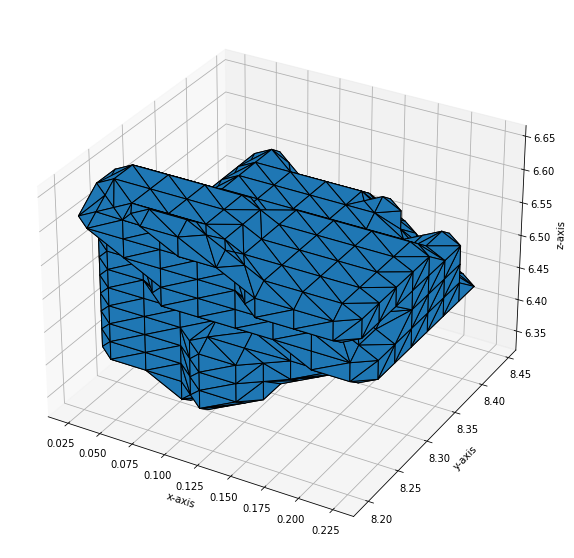

In [22]:
# Set so only particle 895 is meshed
single_particle_iso = 807
print('Generating surface meshes...')
# Create list with single particleID (single_particle_iso) or all particleIDs
if single_particle_iso is not None:
    particle_list = [int(single_particle_iso)]
else:
    particle_list = np.arange(1, n_particles + 1, dtype=int)
# Iterate through particles and save as STL files
for particleID in particle_list:
    # Isolate Individual Particles
    imgs_particle = segment.isolate_particle(segment_dict, particleID)
    # Do Surface Meshing - Marching Cubes
    verts, faces, normals, values = measure.marching_cubes(
        imgs_particle, step_size=ui_voxel_step_size
    )
    # Create save path
    fn = (
        f'{ui_output_filename_base}'
        f'{str(particleID).zfill(n_particles_digits)}.stl'
    )
    stl_save_path = Path(ui_stl_dir_location) / fn
    # Save STL
    if ui_stl_overwrite and stl_save_path.exists():
        stl_save_path.unlink()
    segment.save_stl(
        stl_save_path, verts, faces, spatial_res=ui_spatial_res, 
        suppress_save_message=ui_suppress_save_msg
    )
print('--> All .stl files written!')
fig, ax = segment.plot_stl(stl_save_path)
plt.show()

### Erode particle before marching cubes

Generating surface meshes...
STL saved: C:\Users\gusb\Research\PSAAP\STL-files\F63b\F63b_0807.stl
--> All .stl files written!


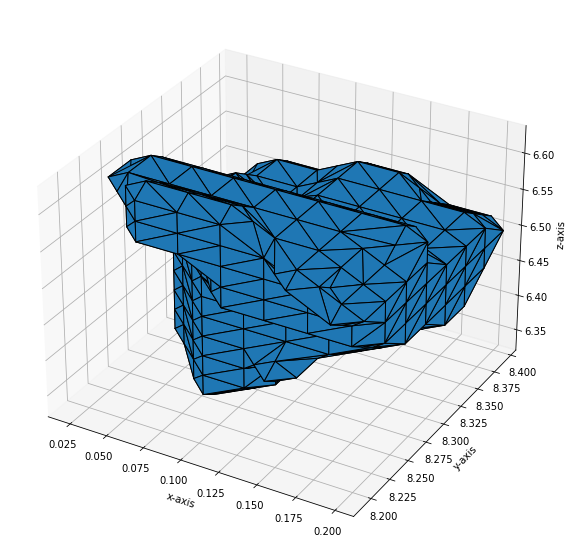

In [23]:
print('Generating surface meshes...')
# Create list with single particleID (single_particle_iso) or all particleIDs
if single_particle_iso is not None:
    particle_list = [int(single_particle_iso)]
else:
    particle_list = np.arange(1, n_particles + 1, dtype=int)
# Iterate through particles and save as STL files
for particleID in particle_list:
    # Isolate Individual Particles
    imgs_particle = segment.isolate_particle(
        segment_dict, 
        particleID,
        erode=True,
    )
    # Do Surface Meshing - Marching Cubes
    verts, faces, normals, values = measure.marching_cubes(
        imgs_particle, step_size=ui_voxel_step_size
    )
    # Create save path
    fn = (
        f'{ui_output_filename_base}'
        f'{str(particleID).zfill(n_particles_digits)}.stl'
    )
    stl_save_path = Path(ui_stl_dir_location) / fn
    # Save STL
    if ui_stl_overwrite and stl_save_path.exists():
        stl_save_path.unlink()
    segment.save_stl(
        stl_save_path, verts, faces, spatial_res=ui_spatial_res, 
        suppress_save_message=ui_suppress_save_msg
    )
print('--> All .stl files written!')
fig, ax = segment.plot_stl(stl_save_path)
plt.show()